In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width: 98% !important }</style>'))

In [2]:
from utilities import *

In [3]:
import joblib
from numba import jit 
from sklearn.preprocessing import normalize
import seaborn as sns

sns.set()

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

## Import Data

In [6]:
pin = read_pin('../Data/pin.csv')
test_pin = read_pin('../Data/testPin.csv')
ble = read_ble('../Data/ble.csv')

In [7]:
data_1 = read_data('../Data/rssi5.csv')
data_2 = read_data('../Data/rssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [8]:
test_1 = read_data('../Data/testRssi.csv')
test_2 = read_data('../Data/testRssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [9]:
data = pd.concat([data_1, data_2], axis=0)
test = pd.concat([test_1, test_2], axis=0)

In [10]:
test.shape

(27229, 19)

## Train Validation Split

In [11]:
train, validation = train_validation_split(data)

In [12]:
print(train.shape)
print(validation.shape)

(102033, 19)
(11337, 19)


In [13]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        data[s].fillna(ss, inplace=True)

def impute(data):
    rolling_win = 30

    data = data.sort_values("time")
    data_rolled = data.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
    data_imputed = data_rolled.set_index("location").groupby("location").ffill()
    data_imputed.reset_index(inplace=True)
    data_imputed["X"] = data_imputed["location"].apply(lambda x: pin[x]["X"] if x[0] == 'V' else test_pin[x]["X"])
    data_imputed["Y"] = data_imputed["location"].apply(lambda x: pin[x]["Y"] if x[0] == 'V' else test_pin[x]["Y"])
    linear_impute(data_imputed)
    return data_imputed

In [14]:
train_imputed = impute(train)
validation_imputed = impute(validation)
test_imputed = impute(test)

In [15]:
train_imputed[scanners] = normalize(train_imputed[scanners] + 100)
validation_imputed[scanners] = normalize(validation_imputed[scanners] + 100)
test_imputed[scanners] = normalize(test_imputed[scanners] + 100)

In [16]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,...,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C,X,Y
0,V1_10,30171,0.270859,0.233392,0.211301,0.353549,0.281666,0.193480,0.167370,0.284954,...,0.207280,0.113343,0.307202,0.356753,0.255005,0.218772,0.043828,0.278136,11.17660,5.29753
1,V1_10,30172,0.269998,0.232650,0.210630,0.352425,0.280771,0.192865,0.184881,0.284048,...,0.206622,0.112983,0.306226,0.355619,0.254194,0.218076,0.043688,0.277252,11.17660,5.29753
2,V1_10,30173,0.323051,0.228668,0.207025,0.346393,0.275966,0.189564,0.181716,0.279187,...,0.203085,0.111049,0.300985,0.349533,0.249844,0.214344,0.042941,0.272507,11.17660,5.29753
3,V1_10,30176,0.322614,0.228359,0.206745,0.345925,0.275592,0.189307,0.181471,0.278809,...,0.202811,0.110899,0.300577,0.352859,0.249506,0.214054,0.042883,0.272206,11.17660,5.29753
4,V1_10,30177,0.323185,0.228763,0.207111,0.346537,0.276080,0.189643,0.181792,0.279303,...,0.203170,0.111095,0.301110,0.348434,0.249948,0.214433,0.042959,0.272688,11.17660,5.29753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102028,V1_9,31037,0.272912,0.159663,0.211646,0.328608,0.167089,0.100253,0.222785,0.412153,...,0.200507,0.100253,0.306330,0.263629,0.303545,0.206076,0.066836,0.367595,8.17867,5.28213
102029,V1_9,31039,0.275097,0.160941,0.213341,0.312151,0.168427,0.101056,0.224569,0.415453,...,0.202112,0.101056,0.308783,0.265740,0.305976,0.198370,0.067371,0.370539,8.17867,5.28213
102030,V1_9,31040,0.275097,0.140356,0.213341,0.312151,0.168427,0.123513,0.224569,0.415453,...,0.202112,0.101056,0.310654,0.265740,0.305976,0.198370,0.067371,0.370539,8.17867,5.28213
102031,V1_9,31042,0.273806,0.139697,0.212339,0.310686,0.167636,0.122933,0.223515,0.424679,...,0.201164,0.100582,0.309196,0.264493,0.304539,0.197438,0.067055,0.368800,8.17867,5.28213


In [17]:
X_train, y_train = train_imputed[scanners].copy(), train_imputed[["X", "Y"]].copy()
X_validation, y_validation = validation_imputed[scanners].copy(), validation_imputed[["X", "Y"]].copy()
X_test, y_test = test_imputed[scanners].copy(), test_imputed[["X", "Y"]].copy()

In [18]:
series = data[data['location'] == 'V1_22']['E96AF2C858BA']

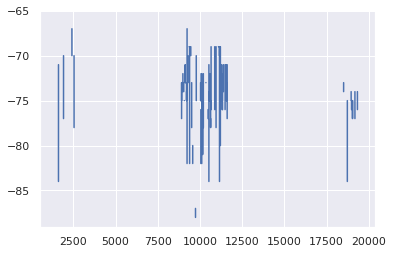

In [19]:
plt.plot(series)

In [21]:
@jit(nopython=True)
def hampel_filter(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    indices = []
    
    for i in range((window_size),(n - window_size)):
        x0 = np.nanmedian(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.nanmedian(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [24]:
res, outlier_ind = hampel_filter(series.values, 10)

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


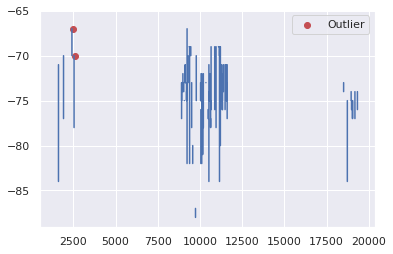

In [27]:
plt.plot(series);
plt.scatter(outlier_ind, series[outlier_ind], c='r', label='Outlier')
plt.legend();